# Vault TFE Auth Plugin

## Overview

The aim of this Vault authentication plugin is to provide Terraform Cloud or Enterprise with a "window of trust", it can use to retrieve secrets from Vault.

This means you will not need to configure any kind of static secret material for your terraform execution to be able to use Vault.

*TFE Auth* is an authentication plugin for [HashiCorp Vault](https://www.vaultproject.io/), but do not assume some kind of official support from HashiCorp. You should make your own decision whether it is safe or not to use this plugin in your environment.

## Prerequisites

* Software and versions
  * Vault 1.7.3+
  * Terraform 1.0+
* Credentials
  * AWS Credentials

### Set Main Environment Variables

In [3]:
export RED="\e[0;31m" YELLOW="\e[0;33m" BLDYELLOW="\e[1;33m" GREEN="\e[0;32m"
export CYAN="\e[0;36m" BLUE="\e[0;34m" WHITE="\e[0;37m" BLDWHITE="\e[1;37m"
export NC="\e[0m"
# Some commands may have sensitive information. Prevent commands starting with a space to be saved to shell history.
HISTCONTROL=ignoreboth # do not save lines that begin with space in history

printf "${GREEN}# Set MAIN_DIR for future reference.${NC}\n"
export MAIN_DIR=${PWD}

# Set MAIN_DIR for future reference.l


: 1

Be sure to replace `TF_ORG` and `TF_WS_NAME` with your own values.

In [4]:
export TF_GIT_DIR="config/terraform/vault-plugin-auth-tfe"
printf "${GREEN}# Set Terraform Variables.${NC}\n"
printf "\n$MAIN_DIR \n $TF_GIT_DIR \n"

# Set Terraform Variables.

/Users/pephan/OneDrive/code/vault_transit_test/hc_demos-jupyter/Vault 
 config/terraform/vault-plugin-auth-tfe 


: 1

Be sure to replace `VAULT_ADDR` with your own values.

In [71]:
printf "${GREEN}# Set Vault Variables.${NC}\n"
export VAULT_PORT=8200
export VAULT_TOKEN=root
export VAULT_ADDR=http://localhost:${VAULT_PORT}
# export VAULT_LICENSE=$(cat ../../license/vault.hclic)
# Set dir env vars. Create required directory.
# WORK_DIR=config/vault
# mkdir -p config/vault/{data,logs,config}

# Set Vault Variables.
cat: ../../license/vault.hclic: Not a directory


: 1

### AWS Credentials

`terraform` will use credentials set in your environment or through other means as described in the [Terraform documentation](https://www.terraform.io/docs/providers/aws/index.html#environment-variables). This guide will assume you are using the "**Environment Variables**" method.

Add your AWS credentials as two environment variables. Set your `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY` replacing `AAAAAA` with your own values.

In [ ]:
 export AWS_ACCESS_KEY_ID=AAAAAA
 export AWS_SECRET_ACCESS_KEY=AAAAAA
#  export AWS_SESSION_TOKEN=AAAAAA

NOTE: If you use `doormat`, then use this method.

In [158]:
alias awscredsenv='doormat --smoke-test || doormat -r && eval $(doormat aws -a $account)'
awscredsenv

FATA[0001] unexpected HTTP status 401 UNAUTHORIZED, want 200 
==> Refreshing Doormat Credentials
==> Successfully refreshed Doormat credentials!


: 1

### Clone Repo

In [5]:
git clone https://github.com/gitrgoliveira/vault-plugin-auth-tfe $TF_GIT_DIR

Cloning into 'config/terraform/vault-plugin-auth-tfe'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 288 (delta 149), reused 212 (delta 88), pack-reused 0
Receiving objects: 100% (288/288), 1.95 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (149/149), done.


: 1

In [14]:
cd $MAIN_DIR/$TF_GIT_DIR

: 1

## AWS Prerequisites

### Create the vault-account IAM user on the primary account - TESTING

In [ ]:
vaultacct=$(aws iam create-user --user-name=vault-account --profile=primary)
echo $vaultacct
vaultarn=$(echo $vaultacct | jq .User.Arn -r)

In [160]:
aws iam create-user --user-name=vault-account


An error occurred (AccessDenied) when calling the CreateUser operation: User: arn:aws:sts::711129375688:assumed-role/se_demos_dev-developer/pphan@hashicorp.com is not authorized to perform: iam:CreateUser on resource: arn:aws:iam::711129375688:user/vault-account


: 1

## Workflow overview
![Workflow overview](https://raw.githubusercontent.com/gitrgoliveira/vault-plugin-auth-tfe/main/images/vault_plugin_workflow.png?raw=true "Workflow overview")

## TFE/TFC assumptions

The following items are needed and currently available. We assume they will still be available for the foreseeable future.

 - TFE/TFC generates a RUN ID that is unique for that TFE Workspace.
 - Plans or applies are always executed within TFE/TFC (i.e. remote operations)
   - These can also be using terraform remote agents.
 - TFE/TFC generates a different token during plan and the apply stages
 - The following environment variables are available:
   - `TF_VAR_TFE_RUN_ID`
   - `TF_VAR_TFC_WORKSPACE_NAME`
 - The TFE/TFC token must have permissions to:
   - [Get the current run ID details](https://www.terraform.io/docs/cloud/api/run.html#get-run-details)
   - [Get the current workspace details](https://www.terraform.io/docs/cloud/api/workspaces.html#show-workspace)
   - [Get the token account details](https://www.terraform.io/docs/cloud/api/account.html#get-your-account-details)

### Retrieving the TFE/TFC token
The TFE/TFC token lives in more than one place. I recommend using the credentials file location.

The credentials file within the TFE/TFC worker lives one of these places, depending if you are using Terraform Agents:
 - `/tmp/cli.tfrc` for code run within TFC/TFE
 - `${path.cwd}/../.terraformrc` for code running in TFC Agents

The TFE/TFC token also exists as an environment variable `ATLAS_TOKEN`.

See `terraform/demo/login_env.tf.example` for an example of that.

In [106]:
cat $MAIN_DIR/$TF_GIT_DIR/terraform/demo/login_env.tf.example

// Vault auth during Planning time - can only have static query elements
data "external" "vault_login_plan" {
  program = ["bash", "${path.module}/vault_login.sh"]
  query = {
    role             = "workspace_role"
    VAULT_ADDR       = var.VAULT_ADDR
    VAULT_LOGIN_PATH = "v1/auth/tfe-auth/login"
  }
}

// Vault auth during Apply time - must have a dynamic element
data "external" "vault_login_apply" {
  program = ["bash", "${path.module}/vault_login.sh"]
  query = {
    role             = "workspace_role"
    VAULT_ADDR       = var.VAULT_ADDR
    VAULT_LOGIN_PATH = "v1/auth/tfe-auth/login"
    always_run       = timestamp()
  }
}

provider "vault" {
  address    = var.VAULT_ADDR
  token      = data.external.vault_login_apply == null ? data.external.vault_login_plan.result.VAULT_TOKEN : data.external.vault_login_apply.result.VAULT_TOKEN
  token_name = "terraform-${var.TFE_RUN_ID}"
}

// just a test.
resource "vault_generic_secret" "example" {
  path = "secret/hello"

  data_json = <

: 1

## Vault Authentication

### Conditions
This plugin will issue a token then the following criteria are met:

 - The TFE/TFC Token provided has the above mentioned permissions
 - The TFE/TFC Token is a *Service account* token
 - The Run ID provided is in the state "planning" or "applying"
 - The Run ID belongs to the Workspace that is being sent.
 - The Workspace name is in the list of the allowed workspaces for that Role.
 - The Workspace belongs to the TFC/E Organisation configured in the auth backend

### Vault clients / identity
This authentication backend can be configured to use/create different entities depending on the run status: `planning` or `applying`.

This means there is an entity metadata entry key `RunStatus` and the display name is changed to `<organization>/<workspace>/<run_status>`

To achieve this behaviour, you need to set `use_run_status` to `true`
``` bash
vault write auth/tfe-auth/config organization=<org> use_run_status=true
```

With this you can issue **read-only** policies/credentials to entities in `planning` mode and higher priveleged credentials for `applying` mode.
_This is particularly useful when using VCS backed workspaces with speculative plans_.

#### Note
> This setting may increase your pipeline security, but it will also double up on the number of Vault Clients required per TFC/E Workspace

## Usage / Demo

Here is a diagram of the steps that would be performed.

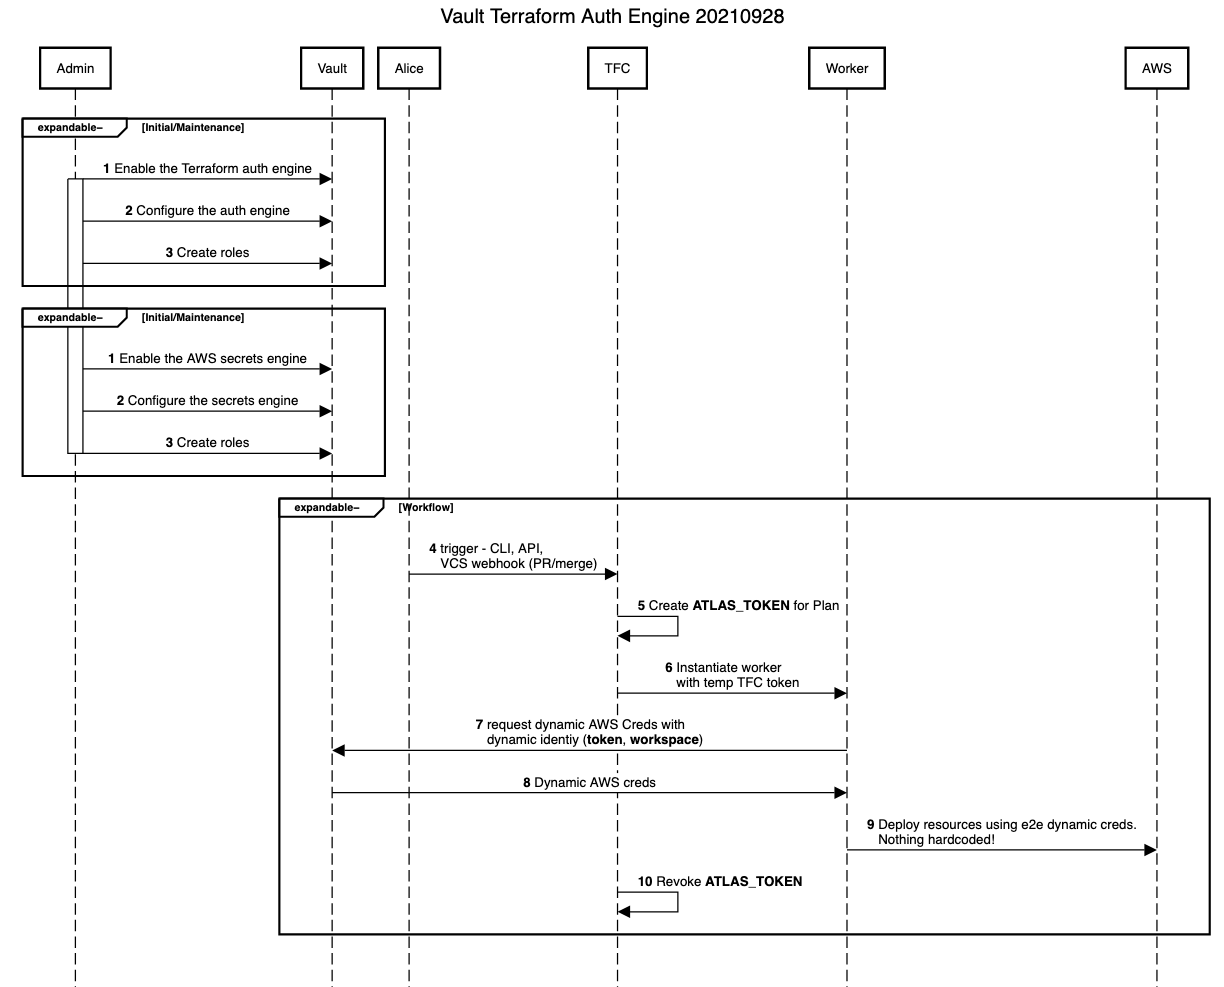

All setup commands can be run using the provided `Makefile`.

However, it may be educational to look at the commands to gain a greater understanding of how Vault registers plugins.

Using the `Makefile` will result in running the Vault server in `dev` mode.

> Do not run Vault in `dev` mode in production. The `dev` server allows you to configure the plugin directory as a flag, and automatically registers plugin binaries in that directory. In production, plugin binaries must be manually registered.

> For the AWS demo, please ensure your AWS credentials have been added to the environment.

Modify `Makefile`. Change the `dev-listen-address` to `0.0.0.0`. We will also have Vault start in the background.

In [114]:
sed -i'.bak' \
  -e "s/address=.*:8200/address=0.0.0.0:8200 > vault.log 2>\&1 \&/" Makefile

: 1

In [39]:
cat Makefile

GOARCH = amd64

UNAME = $(shell uname -s)

ifndef OS
	ifeq ($(UNAME), Linux)
		OS = linux
	else ifeq ($(UNAME), Darwin)
		OS = darwin
	endif
endif

.DEFAULT_GOAL := all

all: fmt build start

build: fmt
	GOOS=$(OS) GOARCH="$(GOARCH)" go build -o vault/plugins/vault-plugin-auth-tfe cmd/vault-plugin-auth-tfe/main.go

start:
	# run this first -->>> eval $(doormat aws --account se_demos_dev)
	vault server -dev -dev-root-token-id=root \
	-dev-plugin-dir=./vault/plugins -log-level=debug \
	-dev-listen-address=0.0.0.0:8200 > vault.log 2>&1 &

enable:
# fad4d28b6f57ca6a1acd49b948e0a279d805280c461bb29fcb8781e57c1c3562
	# vault plugin register -sha256=fad4d28b6f57ca6a1acd49b948e0a279d805280c461bb29fcb8781e57c1c3562 auth vault-plugin-auth-tfe
	vault auth enable -path=tfe-auth vault-plugin-auth-tfe

clean:
	rm -f ./vault/plugins/vault-plugin-auth-tfe

fmt:
	go fmt $$(go list ./...)

test:
	# vault write -force auth/tfe-auth/config
	vault write auth/tfe-auth/config organization=org2 terraform_host=

: 1

Run `make` to setup environment. It will build the Vault plugin binary and run Vault in `dev` mode.

In [115]:
# Build TFE Auth plugin and start Vault dev server with plugin automatically registered
make

go fmt $(go list ./...)
GOOS=darwin GOARCH="amd64" go build -o vault/plugins/vault-plugin-auth-tfe cmd/vault-plugin-auth-tfe/main.go
# run this first -->>> eval 
vault server -dev -dev-root-token-id=root \
	-dev-plugin-dir=./vault/plugins -log-level=debug \
	-dev-listen-address=0.0.0.0:8200 > vault.log 2>&1 & > vault.log 2>&1 &


: 1

See Vault log. You will see Unseal Key, Root Token, and dev plugins.

In [116]:
tail vault.log

seal/unseal the Vault or re-authenticate.

Unseal Key: C3fnFgQcdfVqToh1A/yPdW+z3mpj9Y92F+ZK8AiZOd0=
Root Token: root

The following dev plugins are registered in the catalog:
    - vault-plugin-auth-tfe

Development mode should NOT be used in production installations!



: 1

Go to `terraform/demo` folder.

In [118]:
pushd terraform/demo

~/OneDrive/code/vault_transit_test/hc_demos-jupyter/Vault/config/terraform/vault-plugin-auth-tfe/terraform/demo ~/OneDrive/code/vault_transit_test/hc_demos-jupyter/Vault/config/terraform/vault-plugin-auth-tfe ~/OneDrive/code/vault_transit_test/hc_demos-jupyter/Vault/config/terraform/vault-plugin-auth-tfe


: 1

### option - Download Binary

A binary can also be downloaded from [the releases page](https://github.com/gitrgoliveira/vault-plugin-auth-tfe/releases).

If instead you are installing this plugin in your Vault environment, then please do this first

```bash
chmod +x /etc/vault.d/plugins/vault-plugin-auth-tfe
# if your vault is using mlock (which it does by default)
setcap cap_ipc_lock=+ep /etc/vault.d/plugins/vault-plugin-auth-tfe
vault plugin register -sha256=84ff2af144de37792d546207e42b618cef027a692bf0d32c324555ba28ca301e auth vault-plugin-auth-tfe
```
The sha256 sum available from [the releases page](https://github.com/gitrgoliveira/vault-plugin-auth-tfe/releases) only validates the zip file.
To get the sha256 sum, please run the following command:
```bash
shasum -a 256 /etc/vault.d/plugins/vault-plugin-auth-tfe > /tmp/vault-plugin-auth-tfe.sha256
```

To login using the tfe auth method, this is the command, but it will not work unless it's run within TFC/E.

```bash
$ vault write auth/tfe-auth/login role=workspace_role \
		workspace=$TFC_WORKSPACE_NAME \
		run-id=$TFC_RUN_ID \
		atlas-token=$ATLAS_TOKEN

```

With terraform, use the code in [terraform/demo/login_file.tf](terraform/demo/login_file.tf)
<details><summary></summary>
```
provider "vault" {
  address    = "http://vault_address:8200"
  token_name = "terraform-${var.TFE_RUN_ID}"
  auth_login {
    path = "auth/tfe-auth/login"
    parameters = {
      role      = "workspace_role"
      workspace = var.TFC_WORKSPACE_NAME
      run-id    = var.TFE_RUN_ID
      # For code that is running within TFC/TFE or using an external agent
      tfe-credentials-file = try(filebase64("${path.cwd}/../../../.terraformrc"),
                                  filebase64("/tmp/cli.tfrc"))
    }
  }
}
```
</details>

## Setup Vault

Modify `helper.sh` script. This sets your `VAULT_ADDR` for the setup scripts.

In [73]:
#echo "export VAULT_ADDR=$VAULT_ADDR" > helper.sh

: 1

### Explore setup Script

Let's explore the `01.setup_vault.sh` script

Set VAULT_ADDR

```bash
# Open a new terminal window and export Vault dev server http address
export VAULT_ADDR='http://127.0.0.1:8200'
```

Create a policy (`terraform-policy`) for the terraform auth plugin.

```shell
vault policy write terraform-policy - << EOF
path "auth/token/create" {
    capabilities = ["update"]
}

path "secret/data/*" {
  capabilities = ["read","create", "delete", "update"]
}
path "secret/*" {
    capabilities = ["read", "create", "delete", "update"]
}

path "aws/sts/deploy" {
  capabilities = ["read"]
}
EOF
```

Enable the TFE plugin
```bash
vault auth enable -path=tfe-auth vault-plugin-auth-tfe
```

Configure the Authentication backend. By default it points to `app.terraform.io`
```bash
vault write auth/tfe-auth/config organization=pphan use_run_status=true
# vault write auth/tfe-auth/config organization=pphan \
#     terraform_host=https://tfe.ric.gcp.hashidemos.io
vault read auth/tfe-auth/config
```

* `use_run_status=true`

Add login roles
```bash
vault write auth/tfe-auth/role/workspace_role workspaces=* \
    policies=default,terraform-policy
vault read auth/tfe-auth/role/workspace_role
```

Modify `01.setup_vault.sh` script. Need to change organization.

In [66]:
TF_ORG=pphan
sed -i '.bak' -e "s/organization=.* /organization=${TF_ORG} /" ./01.setup_vault.sh
#awk '{if (NR>=4) print}' #tail -n +4

: 1

Verify that organ

In [119]:
cat ./01.setup_vault.sh

#! /bin/bash
source helper.sh

vault policy write terraform-policy - << EOF
path "auth/token/create" {
    capabilities = ["update"]
}

path "secret/data/*" {
  capabilities = ["read","create", "delete", "update"]
}
path "secret/*" {
    capabilities = ["read", "create", "delete", "update"]
}

path "aws/sts/deploy" {
  capabilities = ["read"]
}

EOF

vault auth enable -path=tfe-auth vault-plugin-auth-tfe
vault write auth/tfe-auth/config organization=pphan use_run_status=true
# vault write auth/tfe-auth/config organization=pphan \
#     terraform_host=https://tfe.ric.gcp.hashidemos.io

vault read auth/tfe-auth/config
vault write auth/tfe-auth/role/workspace_role workspaces=* \
    policies=default,terraform-policy

vault read auth/tfe-auth/role/workspace_role


: 1

* `terraform_host` - if TFE and not https://app.terraform.io
* `user_run_status=true` - not sure what this does?
* `workspaces=<list>` - workspaces that role applies to; `*` for all workspaces

### Run setup script

In [120]:
./01.setup_vault.sh

Success! Uploaded policy: terraform-policy
Success! Enabled vault-plugin-auth-tfe auth method at: tfe-auth/
Success! Data written to: auth/tfe-auth/config
Key               Value
---               -----
organization      pphan
terraform_host    https://app.terraform.io
use_run_status    true
Success! Data written to: auth/tfe-auth/role/workspace_role
Key                        Value
---                        -----
policies                   [default terraform-policy]
token_bound_cidrs          []
token_explicit_max_ttl     0s
token_max_ttl              0s
token_no_default_policy    false
token_num_uses             0
token_period               0s
token_policies             [default terraform-policy]
token_ttl                  0s
token_type                 default
workspaces                 [*]


: 1

Expected Output
```shell
Success! Uploaded policy: terraform-policy
Success! Enabled vault-plugin-auth-tfe auth method at: tfe-auth/
Success! Data written to: auth/tfe-auth/config
Key               Value
---               -----
organization      pphan
terraform_host    https://app.terraform.io
use_run_status    true
Success! Data written to: auth/tfe-auth/role/workspace_role
Key                        Value
---                        -----
policies                   [default terraform-policy]
token_bound_cidrs          []
token_explicit_max_ttl     0s
token_max_ttl              0s
token_no_default_policy    false
token_num_uses             0
token_period               0s
token_policies             [default terraform-policy]
token_ttl                  0s
token_type                 default
workspaces                 [*]
```

Note details of role:

* `organization`
* `terraform_host`

## Setup Vault AWS

For the AWS demo, vault needs to be setup with [terraform/demo/02.setup_vault_aws.sh](terraform/demo/02.setup_vault_aws.sh) and the code in here is fairly simple [terraform/demo/aws.tf](terraform/demo/aws.tf)

### Explore setup vault aws script

Enable AWS secrets engine. 2 minute default ttl. 4 minute max ttl.

```shell
vault secrets enable  \
   -default-lease-ttl=120s \
   -max-lease-ttl=240s \
   aws || true
```

Configure AWS secrets engine.
```shell
vault write aws/config/root \
   region=us-east-1
```

* This configuration assumes that you AWS Creds configured as enviornmental variables.

Configure AWS role.
```shell
vault write aws/roles/deploy \
   role_arns=arn:aws:iam::711129375688:role/ricardo_se_demo \
   credential_type=assumed_role \
   default_sts_ttl=1800 \
   max_sts_ttl=3600
```

View Setup Vault AWS script. Confirm that `role_arns` is correct.

In [121]:
cat ./02.setup_vault_aws.sh

#! /bin/bash
#
source helper.sh

vault secrets enable  \
   -default-lease-ttl=120s \
   -max-lease-ttl=240s \
   aws || true

vault write aws/config/root \
   region=us-east-1

vault write aws/roles/deploy \
   role_arns=arn:aws:iam::711129375688:role/ricardo_se_demo \
   credential_type=assumed_role \
   default_sts_ttl=1800 \
   max_sts_ttl=3600

# vault read aws/creds/deploy


: 1

Setup Vault AWS script

In [144]:
./02.setup_vault_aws.sh

Error enabling: Error making API request.

URL: POST http://localhost:8200/v1/sys/mounts/aws
Code: 400. Errors:

* path is already in use at aws/
Success! Data written to: aws/config/root
Success! Data written to: aws/roles/deploy


: 1

Expected Output
```
Success! Enabled the aws secrets engine at: aws/
Success! Data written to: aws/config/root
Success! Data written to: aws/roles/deploy
```

Getting help for command

In [134]:
vault path-help auth/tfe-auth/role/workspace_role

Request:        role/workspace_role
Matching Route: ^role/(?P<name>\w(([\w-.]+)?\w)?)$

Register an role with the backend.

## PARAMETERS

    bound_cidrs (slice)

        (DEPRECATED) Use "token_bound_cidrs" instead. If this and "token_bound_cidrs" are both specified, only "token_bound_cidrs" will be used.

    max_ttl (duration (sec))

        (DEPRECATED) Use "token_max_ttl" instead. If this and "token_max_ttl" are both specified, only "token_max_ttl" will be used.

    name (string)

        Name of the role.

    num_uses (int)

        (DEPRECATED) Use "token_num_uses" instead. If this and "token_num_uses" are both specified, only "token_num_uses" will be used.

    period (duration (sec))

        (DEPRECATED) Use "token_period" instead. If this and "token_period" are both specified, only "token_period" will be used.

    policies (slice)

        (DEPRECATED) Use "token_policies" instead. If this and "token_policies" are both specified, only "token_policies" will be used.

    

: 1

Confirm aws secrets engine shows up and is configured properly.

In [145]:
vault secrets list
vault read aws/config/root
vault read aws/roles/deploy

Path          Type         Accessor              Description
----          ----         --------              -----------
aws/          aws          aws_4bd16715          n/a
cubbyhole/    cubbyhole    cubbyhole_c37c230a    per-token private secret storage
identity/     identity     identity_5410f1ee     identity store
secret/       kv           kv_a8386fb5           key/value secret storage
sys/          system       system_3e20467a       system endpoints used for control, policy and debugging
Key             Value
---             -----
access_key      n/a
iam_endpoint    n/a
max_retries     -1
region          us-east-1
sts_endpoint    n/a
Key                         Value
---                         -----
credential_type             assumed_role
default_sts_ttl             30m
iam_groups                  <nil>
iam_tags                    <nil>
max_sts_ttl                 1h
permissions_boundary_arn    n/a
policy_arns                 <nil>
policy_document             n/a
role_arns    

: 1

## Terraform

### Terraform Agent

In [150]:
export TFC_AGENT_TOKEN=nzLKXeIeNTo7tg.atlasv1.xxx TFC_AGENT_NAME=vault-agent


Interrupt received.
Please wait for Terraform to exit or data loss may occur.
Gracefully shutting down...


Do you want to cancel the remote operation?
  Only 'yes' will be accepted to cancel.

  Enter a value: 
The remote operation was not cancelled.


: 1

In [154]:
docker run --rm --name tfc-agent \
  -e TFC_AGENT_TOKEN -e TFC_AGENT_NAME \
  hashicorp/tfc-agent:latest &


Interrupt received.
Please wait for Terraform to exit or data loss may occur.
Gracefully shutting down...


Do you want to cancel the remote operation?
  Only 'yes' will be accepted to cancel.

  Enter a value: 
The remote operation was not cancelled.
[1] 63453[?2004l


: 1

### Modify Terraform Configuration

Create/update backend for Terraform.

In [147]:
tee backend.tf <<EOF
terraform {
  backend "remote" {
    organization = "$TF_ORG"
    workspaces {
      name = "vault-login-demo"
    }
  }
  required_providers {
    vault = {
      source = "hashicorp/vault"
    }
  }
}
EOF

terraform {2004l
  backend "remote" {
    organization = "pphan"
    workspaces {
      name = "vault-login-demo"
    }
  }
  required_providers {
    vault = {
      source = "hashicorp/vault"
    }
  }
}


: 1

Create/update `terraform.auto.tfvars` file.

In [152]:
tee terraform.auto.tfvars <<EOF
VAULT_ADDR="http://192.168.17.167:8200" #"${VAULT_ADDR}"
region="us-east-1"
EOF

VAULT_ADDR="http://192.168.17.167:8200" #"http://localhost:8200"
region="us-east-1"


: 1

### Terraform Init, Plan, Apply

In [148]:
terraform init


Initializing the backend...

Initializing provider plugins...
- Reusing previous version of hashicorp/vault from the dependency lock file
- Reusing previous version of hashicorp/aws from the dependency lock file
- Using previously-installed hashicorp/vault v2.23.0
- Using previously-installed hashicorp/aws v3.56.0

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.


: 1

In [155]:
terraform plan

Running plan in the remote backend. Output will stream here. Pressing Ctrl-C
will stop streaming the logs, but will not stop the plan running remotely.

Preparing the remote plan...

To view this run in a browser, visit:
https://app.terraform.io/app/pphan/vault-login-demo/runs/run-uHFtVdBmL53MRgGX

Waiting for the plan to start...

Terraform v1.0.0
on linux_amd64
Initializing plugins and modules...
╷
│ Error: error reading from Vault: Error making API request.
│ 
│ URL: GET http://192.168.17.167:8200/v1/aws/sts/deploy?role_arn=
│ Code: 400. Errors:
│ 
│ * Error assuming role: NoCredentialProviders: no valid providers in chain. Deprecated.
│ 	For verbose messaging see aws.Config.CredentialsChainVerboseErrors
│ 
│   with data.vault_aws_access_credentials.creds,
│   on aws.tf line 6, in data "vault_aws_access_credentials" "creds":
│    6: data "vault_aws_access_credentials" "creds" {
│ 
╵
Operation failed: failed running terraform plan (exit 1)


: 1

In [ ]:
terraform apply

## Verification

### Validate Vault UI

In [94]:
open $VAULT_ADDR

: 1

Go to Access > Entities
Should entity.
Should alias.

### Validate TFC UI

Turn on Terraform debugging. Add the following to Env Var for workspace.

```shell
TF_LOG = DEBUG enabled
```

## Clean up

Remove vault configurations.

In [142]:
vault delete aws/config/root
vault delete aws/roles/deploy
vault secrets disable aws

Success! Data deleted (if it existed) at: aws/roles/deploy


: 1

Stop vault process. All configuration and data will be lost.

In [ ]:
pkill vault

Remove artifacts

## Next steps